# Image Classification using the Interpreter API

This notebook shows you how to use the Interpreter Python API to classify images.

## Preparation

Let's start with downloading an off-the-shelf model. Check out [Kaggle Models](https://www.kaggle.com/models/tensorflow/efficientnet/tfLite) for more image classification models that you can use.

For the different types of model optimization modes used by the models read more [here](https://www.tensorflow.org/lite/performance/post_training_quantization#optimization_methods).

In [118]:
# @title Pick a model
effnet_model_type = "lite0-fp32" # @param ["lite0-int8", "lite0-fp32", "lite0-uint8"]


In [119]:
import pathlib
import kagglehub

# Download latest version
path = kagglehub.model_download(f"tensorflow/efficientnet/tfLite/{effnet_model_type}")
print("Path to model files:", path)

MODEL_PATH = str(next(pathlib.Path(path).rglob('*.tflite')))

Path to model files: /root/.cache/kagglehub/models/tensorflow/efficientnet/tfLite/lite0-fp32/2


## Utilities



In [120]:
#@markdown We implemented some functions to visualize the image classification results. <br/> Run the following cell to activate the functions.
from matplotlib import pyplot as plt
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(images, predictions):
    """Displays a batch of images with the classifications."""
    # Images and predictions.
    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display.
    for i, (image, prediction) in enumerate(zip(images[:rows*cols], predictions[:rows*cols])):
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        subplot = display_one_image(image, prediction, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [121]:
#@markdown Here we load the labels using the TFLite model metadata
import zipfile

# Load label list from metadata.
try:
  with zipfile.ZipFile(MODEL_PATH) as model_with_metadata:
    if not model_with_metadata.namelist():
      raise ValueError('Invalid TFLite model: no label file found.')

    file_name = model_with_metadata.namelist()[0]
    with model_with_metadata.open(file_name) as label_file:
      label_list = label_file.read().splitlines()
      label_list = [label.decode('ascii') for label in label_list]
except zipfile.BadZipFile:
  print(
      'ERROR: Please use models trained with Model Maker or downloaded from TensorFlow Hub.'
  )
  raise ValueError('Invalid TFLite model: no metadata found.')

## Download test images

Let's grab some test images that we'll use later. The images ([1](https://pixabay.com/photos/hamburger-burger-barbeque-bbq-beef-1238246/), [2](https://pixabay.com/photos/cat-kitten-pets-animals-housecat-2934720/)) are from Pixabay.

In [122]:
import urllib

IMAGE_FILENAMES = ['burger.jpg', 'cat.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-tasks/image_classifier/{name}'
  urllib.request.urlretrieve(url, name)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [123]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)
# IMAGE_FILENAMES = list(uploaded.keys())

# print('Uploaded files:', IMAGE_FILENAMES)

Then let's check out the images.

burger.jpg


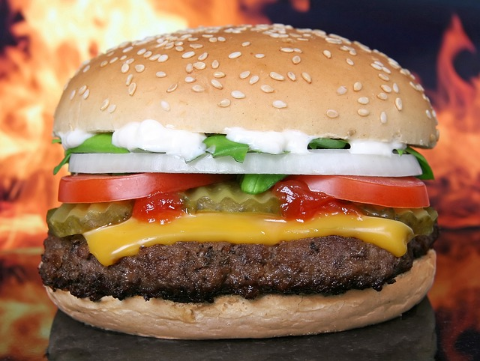

cat.jpg


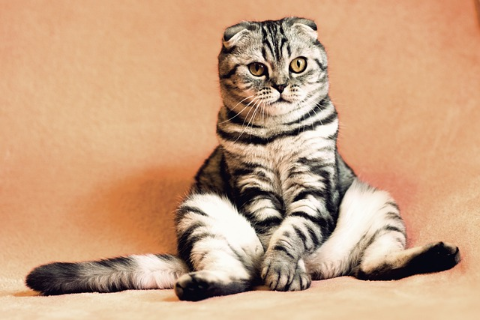

In [124]:
import cv2
from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the images.

images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

## Running inference and visualizing the results

Here are the steps to run image classification using the Interpreter API.

Check out the [Interpreter documentation](https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python) to learn more about configuration options for the Interpreter API.

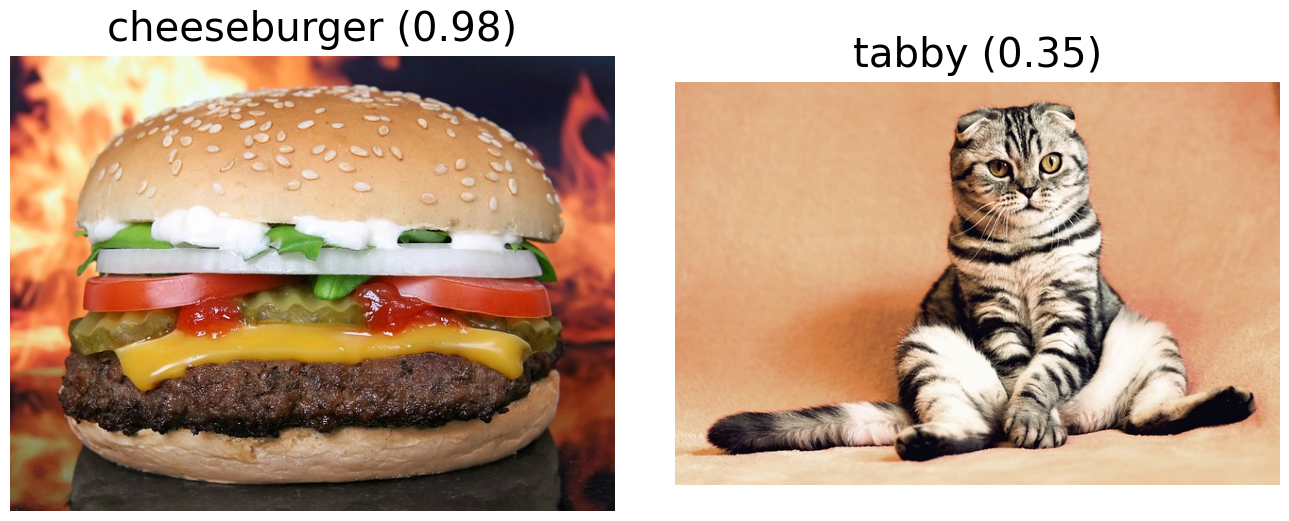

In [125]:
# STEP 1: Import the necessary modules.
import tensorflow as tf
import numpy as np

# Default mean and std normalization parameter for float model.
MEAN = 127
STD = 128

# STEP 2: Load the TFLite model in TFLite Interpreter and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

# STEP 3: Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# STEP 4: Get the input shape, model input/output quantization flags
_, input_height, input_width, _ = input_details[0]['shape']
is_quantized_input = input_details[0]['dtype'] == np.uint8
is_quantized_output = output_details[0]['dtype'] == np.uint8


images = []
predictions = []
for image_name in IMAGE_FILENAMES:
  # STEP 6: Load the input image.
  raw_image = cv2.imread(image_name)
  raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

  # STEP 6: Preprocess the input image as required by the TFLite model.
  image = cv2.resize(raw_image, (input_width, input_height))
  if not is_quantized_input:
    # Normalize the input if it's a float model.
    image = (np.float32(image) - MEAN) / STD

  # STEP 7: Set the input tensor and classify the input image.
  interpreter.set_tensor(input_details[0]['index'], [image])
  interpreter.invoke()
  output_tensor = np.squeeze(interpreter.get_tensor(output_details[0]['index']))

  # STEP 8: Process the classification result. In this case, visualize it.
  if is_quantized_output:
    # Dequantize the results if the model is quantized.
    scale, zero_point = output_details[0]['quantization']
    output_tensor = scale * (output_tensor - zero_point)

  # Get the top output category index.
  top_output_index = np.argmax(output_tensor)

  images.append(raw_image)
  predictions.append(f"{label_list[top_output_index]} ({output_tensor[top_output_index]:.2f})")

display_batch_of_images(images, predictions)